In [1]:
from src import PPO
from src import Env
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ppo=PPO(False,False,False)

In [3]:
env=Env(1,False)
inds=[45,53,11,17,40,74,1,28,63,78,10]

In [11]:
env.regions[inds]

array(['Республика Бурятия', 'Республика Саха (Якутия)',
       'Забайкальский край', 'Камчатский край', 'Приморский край',
       'Хабаровский край', 'Амурская область', 'Магаданская область',
       'Сахалинская область', 'Чукотский автономный округ',
       'Еврейская автономная область'], dtype=object)

In [4]:
T=400
goal=env.p.copy()
goal[29]-=0.04
goal[30]-=0.02
goal[61]-=0.01
goal[inds]+=0.07/len(inds)
obsie,goal=env.reset_curr(goal[None])
obs=torch.from_numpy(obsie).float().to(ppo.device)
obses=torch.zeros((T+1,1,env.n_regions,2)).to(ppo.device)
obses[0]=obs
rewards=[]
goals=torch.from_numpy(goal).float().to(ppo.device)
for step in range(T):
    with torch.no_grad():
        actions_policy=ppo.actor.act(obs,goals)
        actions=actions_policy[0].squeeze().cpu().numpy()
        # actions=ppo.simulate(obs[:,:,0],goals)
        # actions_policy=ppo.actor.act(obs,goals,actions)
        # actions=actions_policy[0].squeeze().cpu().numpy()
    obsie,reward,done,info=env.step(actions)
    obs=torch.from_numpy(obsie).float().to(ppo.device)
    obses[step+1]=obs
    rewards.append(reward)

In [5]:
np.array(rewards).sum(axis=0)

array([-86])

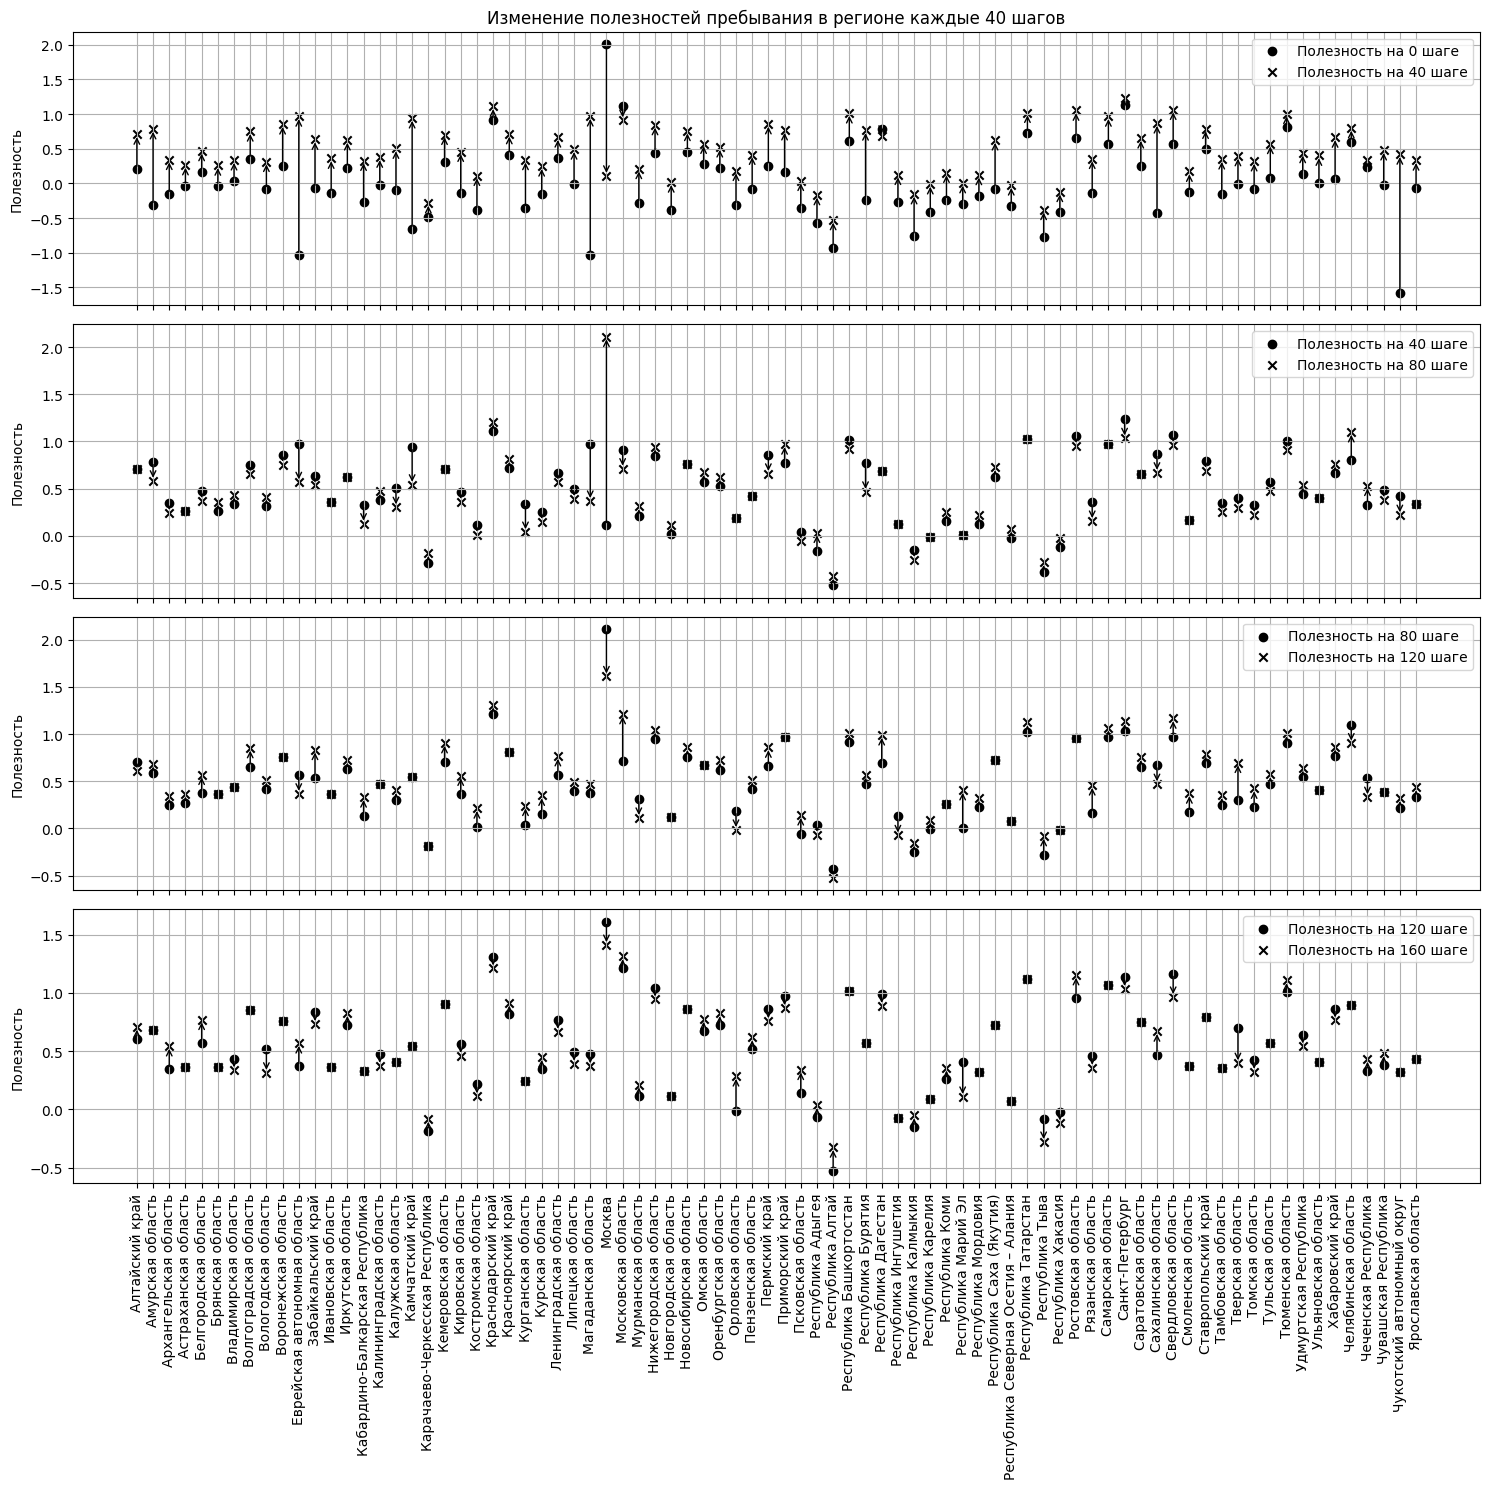

In [6]:
step=40
fig,axes=plt.subplots(4,figsize=(15,15),sharex=True)
for idx,ax in enumerate(axes):
    if idx==0:
        ax.set_title('Изменение полезностей пребывания в регионе каждые {} шагов'.format(step))
    ax.set_ylabel("Полезность")
    ax.scatter(env.regions,obses[idx*step,0,:,1].cpu().numpy(),c="black",label="Полезность на {} шаге".format(idx*step))
    ax.scatter(env.regions,obses[(idx+1)*step,0,:,1].cpu().numpy(),marker="x",c="black",label="Полезность на {} шаге".format((idx+1)*step))
    ax.set_xticks(np.arange(env.n_regions),env.regions,rotation=90)
    ax.legend()
    ax.grid()
    for i in range(ppo.n_regions):
        ax.annotate("", xytext=(i, obses[idx*step,0,i,1].item()), xy=(i, obses[(idx+1)*step,0,i,1].item()),
            arrowprops=dict(arrowstyle="->"))
plt.tight_layout(h_pad=1)
plt.savefig("./output/dU.png")